# Генератор отзывов

## Импорт библиотек

In [1]:
import wget

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import Dataset

%matplotlib inline

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## EDA

### Загрузка датасета

In [2]:
url = 'https://github.com/yandex/geo-reviews-dataset-2023/raw/refs/heads/master/geo-reviews-dataset-2023.tskv'
filename = wget.download(url)

### Преобразование в датафрейм

In [2]:
# Считаем при помощи pandas исходный файл с табуляцией в качестве разделителя, задав нужные нам имена колонок
df = pd.read_csv('geo-reviews-dataset-2023.tskv', sep='\t', header=None, names=['address', 'name_ru', 'rating', 'rubrics', 'text'])
columns = df.columns.to_list()
# Пройдем в цикле по колонкам и удалим из ячеек ключи
for column in columns:
    df[column] = df[column].replace(f'{column}=', '', regex=True)

In [3]:
# Посмотрим первые строки
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


### Базовый анализ датафрейма

Посмотрим основную информацию по нашему датафрейму

In [4]:
# Размер датафрейма
print(f'Размер датафрейма: {df.shape}')

Размер датафрейма: (500000, 5)


In [5]:
# Типы данных
print(df.dtypes)

address    object
name_ru    object
rating     object
rubrics    object
text       object
dtype: object


In [6]:
# Кол-во уникальных значений
df.nunique()

address    191925
name_ru    148461
rating        393
rubrics     32694
text       498918
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  500000 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


Видим, что в колонке 'text' есть пропущенные значения. Поскольку данных у нас очень много, и целиком датасет мы все равно использовать не будем (так как дообучение моделей тогда растянется на несколько недель), просто удалим все строки, где есть пропущенные значения.

In [8]:
df = df.dropna(ignore_index=True)

In [9]:
# Проверим наличие дубликатов
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

1

In [10]:
df.loc[df.duplicated(keep=False), :]

,address,name_ru,rating,rubrics,text
123882,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."
123884,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."


Действительно, у нас есть один дубликат

In [11]:
# Теперь обрежем точку после цифры в колонке 'rating' и приведем колонку к типу int64
df['rating'] = df['rating'].replace('\.', '', regex=True)
df['rating'] = pd.to_numeric(df['rating'])

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Anton\AppData\Local\Temp\ipykernel_14400\2113345063.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['rating'] = df['rating'].replace('\.', '', regex=True)


Посмотрим, как в датасете распределены оценки

<Axes: xlabel='rating', ylabel='Count'>

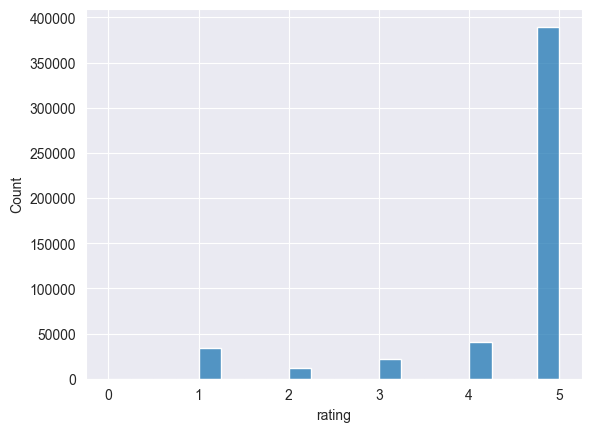

In [12]:
sns.histplot(df['rating'])

In [13]:
# Посмотрим, что из себя представляют отзывы на 0 баллов
df.query('rating == 0').head()

,address,name_ru,rating,rubrics,text
1906,"Республика Карелия, Суоярви, улица Шельшакова, 1",Гостиница Карелия,0,Гостиница,"Гостиница расположенна удобно, если отремонтир..."
2164,"Кемерово, улица Тухачевского, 12",Светофор,0,Магазин автозапчастей и автотоваров;Автоаксесс...,Это мой любимый магазин с запчастями. Можно вс...
3583,"Краснодарский край, Анапа, улица Пушкина, 30",Кубань,0,Санаторий,"Нет растительного масла для салата, нет зубочи..."
3614,"Краснодарский край, Туапсинский район, Новомих...",Счастливый Хотей,0,Гостиница,"Все довольны, и взрослые и дети.\nВкусная еда...."
6384,"Ленинградская область, Выборг, улица Мира, 8А",Атриум,0,Торговый центр,"Большой выбор, очень грамотно и удобно разложе..."


Как мы видим, отзывы на 5 звезд люди оставляют значительно чаще, чем с другим рейтингом. Наверное, в дальнейшем нам стоит сбалансировать классы для обучающей выборки.
Так же есть шум в виде отзывов на 0 баллов (хотя если посмотреть на текст таких отзывов - он в основном положительный).

Добавим в наш датафрейм колонку, в которой будет указана длина отзыва и проанализируем полученный результат.

In [14]:
df['review_length'] = df['text'].str.len()

In [15]:
df['review_length'].describe()

count    499030.000000
mean        303.232533
std         292.609661
min           2.000000
25%         145.000000
50%         215.000000
75%         365.000000
max       20162.000000
Name: review_length, dtype: float64

<Axes: xlabel='review_length', ylabel='Count'>

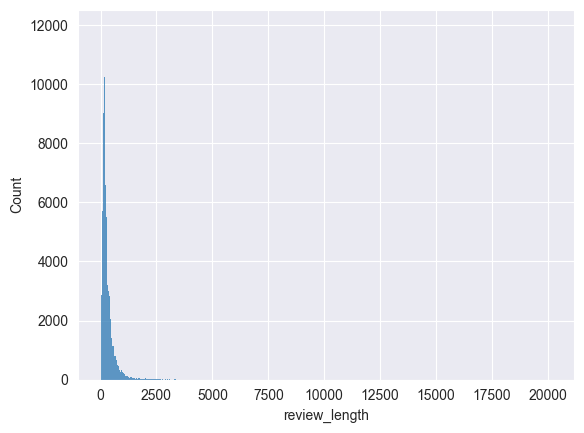

In [16]:
sns.histplot(df['review_length'])

<Axes: ylabel='review_length'>

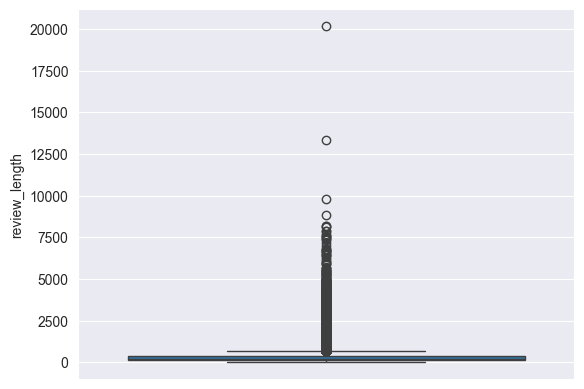

In [17]:
sns.boxplot(df['review_length'])

In [18]:
# Посмотрим, как выглядят отзывы более 10000 символов
df.query('review_length > 10000')['text'].values

array(['Que si, que no...\\nМногажды бывал в этом замечательном отеле, и с каждым разом всё больше и больше эта песня про тупящего влюблённого, являющаяся гимном отеля, всё точнее и точнее описывает качество отдыха. Вообще, этот гимн противоречиям максимально отражает происходящее с Вами на отдыхе в Ялта Интурист.\\nНачинается знакомство с особенностями сервиса со службы размещения (это те, кого называют ресепшн). Приветливость сотрудников на стойке регистрации можно выделить отдельно, Вас всегда встретят с улыбкой, всё расскажут и ответят на Ваши вопросы при заселении, но на чемпионате мира по созданию очередей, они без особого труда возьмут второе место (первое – без шансов конкурентам у транспортной безопасности терминала Аэроэкспресс в Шереметьево). Специальный удобный трансфер быстро перемещает десятки гостей из аэропорта и вокзала в очередь на заселение, где на 6 стойках регистрации работают всего один или два сотрудника. Господа, это, же, элементарно: на время прибытия трансферо

In [19]:
# И также как выглядят отзывы менее 10 символов
df.query('review_length < 10')['text'].values

array(['Круто', 'Круто', 'кайф\\n', 'Все круто', 'Отлично ', 'Отлично!',
       'Прилично ', 'Лучшие!', 'Клас!', 'Класс', 'Хорошо ', 'Удобно',
       'Супер', 'Не плохо ', 'Нормально', 'Спасибо!', 'Отлично',
       'Спасибо', 'Норм', 'Стандарт.', 'Чисто!', 'Все отл', 'Удобно',
       'Хорошо', '10 из 10', 'Ок', 'Вкусно', 'Супер', 'Норм', 'Вкусно',
       'Красавцы', 'Не вкусно', 'Все норм.', 'Профи!', 'Отлично.',
       'Круть', 'Чисто', 'Отлично.', 'Хорошо ', 'Бомба', 'Всё супер',
       'топ топ', 'Норм', 'Вполне!', 'Всё чëтко', 'Вкусно', 'Класс! '],
      dtype=object)

Как видим, у нас присутствуют выбросы (как слишком маленькая длина отзыва, так и слишком большая).
В обоих вариантах отзывы лишены здравого смысла.
В дальнейшем нужно будет удалить эти выбросы из датафрейма.

In [20]:
df_cor = df[['rating', 'review_length']]
df_cor

,rating,review_length
0,3,537
1,5,158
2,1,485
3,4,142
4,5,373
...,...,...
499025,5,76
499026,4,295
499027,4,325
499028,5,502


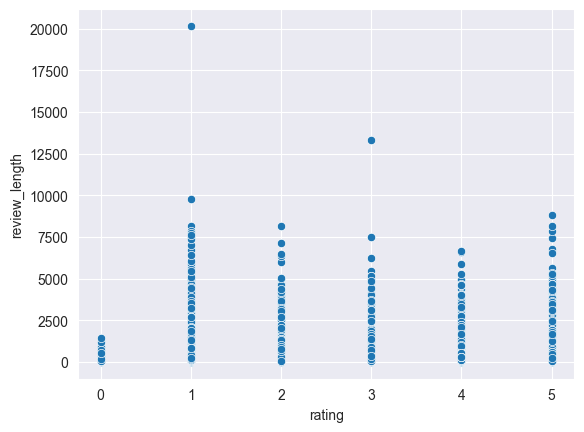

In [21]:
# Диаграмма рассеяния
sns.scatterplot(x='rating', y='review_length', data=df_cor)
plt.show()

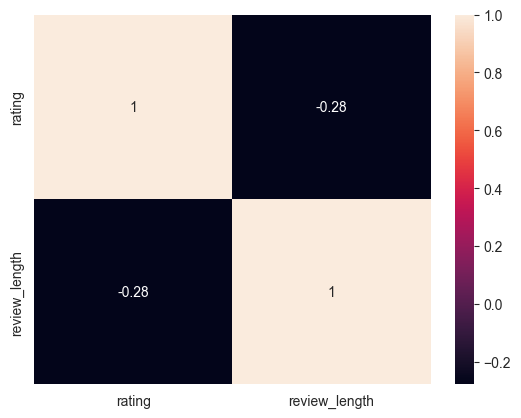

In [22]:
# Корреляционная матрица
corr_matrix = df_cor.corr()

# Визуализируем корреляционную матрицу
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [23]:
# Сохраним наш датафрейм в tsv файл для дальнейшей работы
df.to_csv('geo-reviews-dataset-2023.tsv', sep='\t', index=False)

### Расчет частотности слов

Теперь посчитаем количество уникальных слов в отзывах

In [24]:
# Соберем все тексты отзывов в одну строку
words_list_list = df['text'].to_list()
words_str = ' '.join(str(string) for string in words_list_list)

In [25]:
# Удалим из строки все спец.символы
def remove_chars_from_text(text, chars):
    return "".join([char for char in text if char not in chars])

spec_chars = string.punctuation + '\n\xa0«»\t—…n'

text = remove_chars_from_text(words_str, spec_chars)
text = remove_chars_from_text(text, string.digits)

# Приведем все слова к нижнему регистру
text = text.lower()

In [26]:
# Токенизируем текст
nltk.download('punkt_tab')
text_tokens = word_tokenize(text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [27]:
# Посмотрим статистику по неочищенным словам


# Для применения инструментов частотного анализа библиотеки NLTK необходимо список токенов преобразовать к классу Text
text = nltk.Text(text_tokens)
fdist = FreqDist(text)

print('Статистика по неочищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по неочищенным словам

Всего слов: 21306636

Уникальных слов: 742932

Топ-10 слов по частоте: 
и:  874480
в:  604858
не:  400240
на:  389339
очень:  298972
с:  289708
что:  205890
все:  170685
но:  141965
по:  137147


In [28]:
# Теперь очистим слова от служебных частей речи
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
custom_stopwords = ['очень', 'это', 'всё', 'всем', 'еще', 'ещё']
stopwords_united = russian_stopwords + custom_stopwords
text_with_no_stopwords = [word for word in text if word not in stopwords_united]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# И посмотрим статистику по очищенным словам

fdist = FreqDist(text_with_no_stopwords)

print('Статистика по очищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по очищенным словам

Всего слов: 14173971

Уникальных слов: 742776

Топ-10 слов по частоте: 
персонал:  82456
место:  74975
спасибо:  73776
рекомендую:  60037
просто:  49583
магазин:  46361
хороший:  43166
цены:  42268
вкусно:  40279
быстро:  40030


<Axes: xlabel='Samples', ylabel='Counts'>

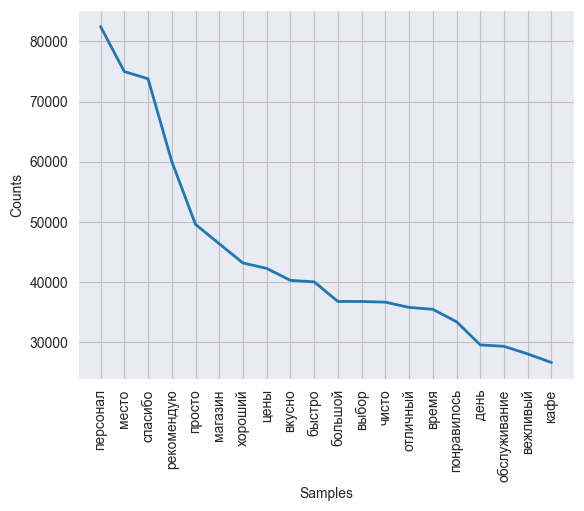

In [30]:
# Чтобы добавить сюда что-нибудь красивое - нарисуем график частоты топ-20 очищенных слов

fdist.plot(20,cumulative=False)

### Облако слов

Составим облако очищенных слов по частоте употребления

In [31]:
wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(fdist)

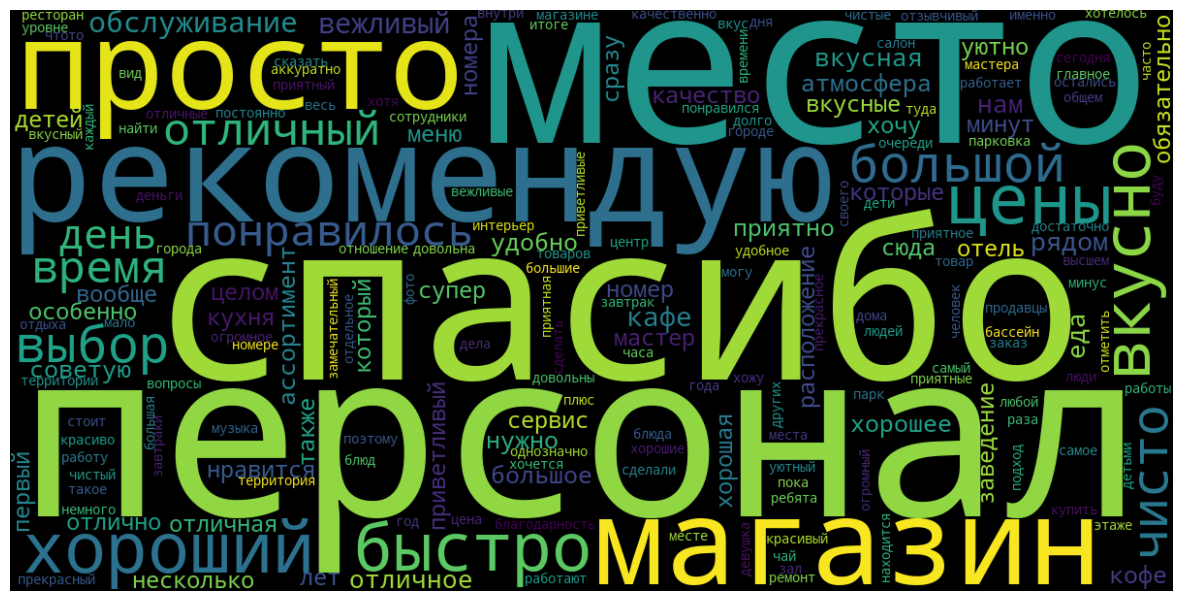

In [32]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Выводы по этапу EDA:
1. Нужно удалить строки с пропущенными значениями
2. Нужно удалить дубликаты
3. Нужно удалить строки с отзывами на 0 баллов
4. Нужно удалить строки со слишком большой и слишком маленькой длиной текста отзыва
5. Возможно, для дальнейшего обучения моделей стоит сбалансировать классы отзывов по значениям рейтига 

## Предобработка

In [33]:
# Исходный датафрейм
df = pd.read_csv('geo-reviews-dataset-2023.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499030 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        499030 non-null  object
 1   name_ru        499030 non-null  object
 2   rating         499030 non-null  int64 
 3   rubrics        499030 non-null  object
 4   text           499030 non-null  object
 5   review_length  499030 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


Строки с пропущенными значениями и дубликаты были удалены на прошлых этапах

Нормализация текстов (удаление спецсимволов, приведение к нижнему регистру):

In [34]:
def normalize_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)
    
    return text

# Применяем функцию ко всем отзывам
df['text'] = df['text'].apply(normalize_text)


Обработка категорий

In [35]:
# Посмотрим сколько уникальных значений по столбцам
df.nunique()

address          191639
name_ru          148456
rating                6
rubrics           31724
text             498805
review_length      3004
dtype: int64

Большое количество уникальных значений по категориальным признакам, считаю применение onehot кодирования нерентабельным

Группировка категорий уникальные значения которых встречаются реже всего

In [36]:
# Cгруппировать все категории, которые встречаются менее чем в 0.00021% случаев
category_counts = df['rubrics'].value_counts(normalize=True)
rare_categories = category_counts[category_counts < 0.0000021].index

rare_categories

Index(['Офис интернет-магазина;Зоомагазин;Доставка продуктов',
       'Спортивный, тренажёрный зал;Спортивная база;Аренда площадок для культурно-массовых мероприятий',
       'Магазин мяса, колбас;Продукты глубокой заморозки;Молочный магазин;Магазин кулинарии;Магазин сыров',
       'Системы водоснабжения и канализации;Отопительное оборудование и системы;Монтаж и обслуживание систем водоснабжения и канализации',
       'Копировальный центр;Печати и штампы;Магазин канцтоваров;Типография',
       'Диагностический центр;Поликлиника для взрослых;Медсанчасть',
       'Банкетный зал;Развлекательный центр;Кейтеринг',
       'Достопримечательность;Магазин подарков и сувениров',
       'Ресторан;Кафе;Зимние сады, веранды, террасы',
       'Курьерские услуги;Грузовые авиаперевозки;Почтовые услуги',
       ...
       'Автомойка;Кофейня;Кофе с собой',
       'Салон оптики;Коррекция зрения;Медицинские изделия и расходные материалы;Контактные линзы',
       'Магазин мебели;Оптовый магазин;Корпусная м

Есть категории которые встречаются редко в датафрейме, но по смыслу разные и могут пригодиться для генерации отзывов. Считаю, что не нужно группировать их в одну категорию.

Удаляем строки с рейтингом 0

In [37]:
# Убираем строки с рейтингом 0
df = df.query("rating > 0")

# Выводим кол-во уникальных значений по колонкам для проверки результата
df.nunique()

address          191595
name_ru          148421
rating                5
rubrics           31715
text             498606
review_length      3004
dtype: int64

<Axes: xlabel='rating', ylabel='Count'>

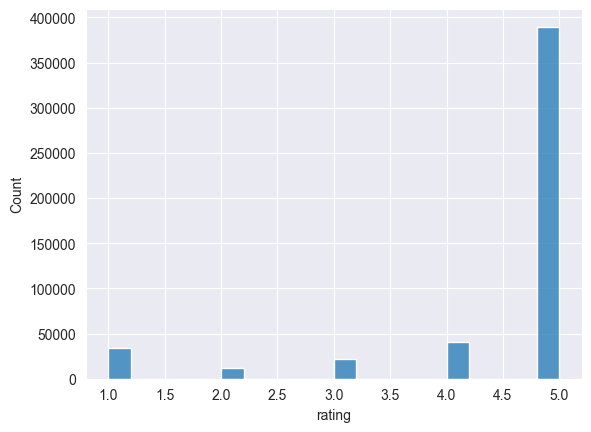

In [38]:
# Выведем график распределения для визуализации
sns.histplot(df['rating'])

In [39]:
# Проверим сколько строк удалилось после преобразований
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498830 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498830 non-null  object
 1   name_ru        498830 non-null  object
 2   rating         498830 non-null  int64 
 3   rubrics        498830 non-null  object
 4   text           498830 non-null  object
 5   review_length  498830 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


Удалилось 200 строк

Удаляем строки со слишком большой и слишком маленькой длиной текста отзыва

In [40]:
# Удаление отзывов с длиной более 4000 слов
df = df.query('review_length < 4000')

# Удаление отзывов с длиной менее 10 слов
df = df.query('review_length > 10')

In [41]:
# Проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


Удалилось еще 191 строка

<Axes: xlabel='review_length', ylabel='Count'>

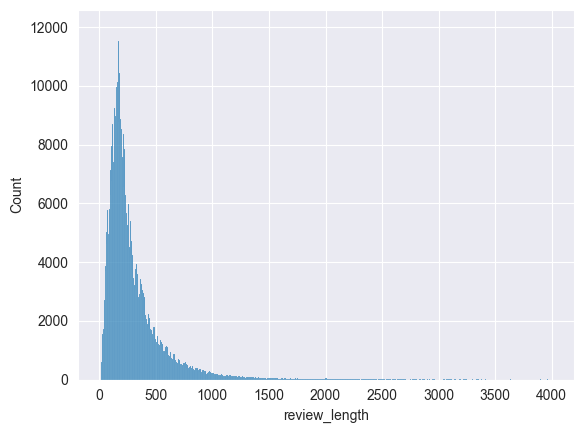

In [42]:
# Выведем график распределения по длине отзывов, для визуализации результата
sns.histplot(df['review_length'])

In [43]:
# Проверим балансировку классов по рейтингу
print(Counter(df['rating']))

Counter({5: 389606, 4: 41096, 1: 34246, 3: 21634, 2: 12057})


Как уже отмечалось выше, присутствует дисбалансировка по рейтингу

Заменяем символы переноса строки (\\n) на пробелы:

In [44]:
df['text'] = df['text'].str.replace('\\n', ' ')

# И еще заменим откуда-то взявшиеся вместо пробелов буквы "n"
df['text'] = df['text'].str.replace('n', ' ')

В итоге получаем очищенные датафрейм df для дальнейшей работы

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


In [46]:
# Сохраним предобработанный датасет в tsv файл
df.to_csv('dataset_preprocessed.tsv', sep='\t', index=False)

### После проблем с дообучением модели было принято решение сбалансировать классы оценок и обрезать датасет до 15000 строк. 

Конечно было бы классно сделать сюда кластеризацию, и сбалансировать места по категориям, но времени у нас на это нет (может, доделаем позже). А пока что сделаем то, что точно успеем.

In [47]:
# Подгрузим файл с прошлого шага
df = pd.read_csv('dataset_preprocessed.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498639 entries, 0 to 498638
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


Пока что у нас в датасете 498639 строк.

In [48]:
# Создадим список, в который отправим категории, которые встречаются в датасете не менее 200 раз
frequent_rubrics = df.rubrics.value_counts().reset_index(name="count").query("count >= 200")['rubrics'].to_list()

# Заполним редкие рубрики NaN (если их нет в списке частх рубрик)
df['rubrics'] = df['rubrics'].apply(lambda rubric: rubric if rubric in frequent_rubrics else np.nan)

# Удалим NaN
df = df.dropna(ignore_index=True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319099 entries, 0 to 319098
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        319099 non-null  object
 1   name_ru        319099 non-null  object
 2   rating         319099 non-null  int64 
 3   rubrics        319099 non-null  object
 4   text           319099 non-null  object
 5   review_length  319099 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.6+ MB


Осталось 319099 строк.

In [50]:
# На всякий случай проверим, осталось ли нужное нам количество строк каждого класса
print(Counter(df['rating']))

Counter({5: 243849, 4: 30943, 1: 19993, 3: 15961, 2: 8353})


Так как нам нужно 15000 строк, а классов оценки у нас 5, то просто наберем по 3000 строк каждого класса.

In [51]:
# Функция для конкатенации датафреймов по рейтингу
def balance_rating(df, len_for_each_rating=3000):
    df_dict = {}
    for rating in range(1, df.rating.nunique()+1):
        # Датафреймы с нужным рейтингом и нужной длины соберем в словарь
        df_dict["df_rating" + str(rating)] = df.query(f'rating == {rating}')[:len_for_each_rating]
    # Сконкатенируем датафреймы из словаря
    df_cropped = pd.concat(df_dict.values(), ignore_index=True)
    return df_cropped


In [52]:
df = balance_rating(df, 3000)

Наглядно посмотрим, что все получилось как надо

<Axes: xlabel='rating', ylabel='Count'>

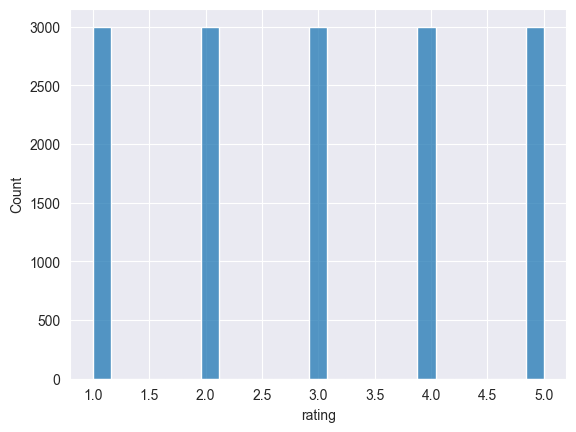

In [53]:
sns.histplot(df['rating'])

In [54]:
# Сохраним обрезанный датасет для дальнейшего удобного использования
df.to_csv('dataset_cropped.tsv', sep='\t', index=False)

## Подготовка данных для подачи на обучение

Для начала структурируем данные, объединим rubrics, rating и text в единый текстовый формат:

Важный момент с форматированными текстами, это нужно для того что бы помочь структурировать данные и облегчить задачу модели. Так же это нужно для улучшения генерации, так после обучения это будет помогать задавать контекст, и при подаче данных в виде например "Category: Restaurants. Rating: 5. Review:" модель сгенерирует отзыв, соответствующий ресторану с высоким рейтингом.

Так же подобная структура упростит расширение, так как мы можем добавлять сюда еще поля если захотим подавать больше параметров на обучения.

In [56]:
# Загрузим обрезанный датасет
df = pd.read_csv('dataset_cropped.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   address        15000 non-null  object
 1   name_ru        15000 non-null  object
 2   rating         15000 non-null  int64 
 3   rubrics        15000 non-null  object
 4   text           15000 non-null  object
 5   review_length  15000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 703.3+ KB


In [57]:
def format_review(row):
    return f"Category: {row['rubrics']}. Rating: {row['rating']}. Review: {row['text']}"

df['formatted_text'] = df.apply(format_review, axis=1)

Далее токенизация.

Тут нам нужно перевести данные в токены, с использованием предобученного токенизатора (осторожно, процесс не быстрый, у меня на локалке занимает от 5 до 15мин.):


In [58]:
# Загрузка токенизатора
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2") # Изменен токенизатор
tokenizer.pad_token = tokenizer.eos_token

# Токенизация данных
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# Пример применения
df['tokenized'] = df['formatted_text'].apply(tokenize_function)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

С помощью datasets из Hugging Face создадим датасет для обучения:

In [59]:
dataset = Dataset.from_pandas(df[['formatted_text']])

# Токенизация всех текстов
def tokenize_data(batch):
    return tokenizer(batch['formatted_text'], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_data, batched=True)


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [60]:
# Разделение на train/test
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

Далее подготовим данные для обработки данных при обучении:

In [61]:
# Создание collator для задачи языкового моделирования
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  
)

`DataCollatorForLanguageModeling` - инструмент из библиотеки Hugging Face, который динамически обрабатывает батчи данных для задач NLP. В данном случае используется для подготовки токенизированных данных к обучению GPT-2, если перечислить что он делает:

1. Формирует батчи
2. Добавлеет специальне токены
3. Упрощяет обработку

В итоге на этапе подготовки данных для обучения мы получили:

1. `train_dataset` и `test_dataset` - датасеты для обучения и валдиации
2. `data_collator` - "подборщик данных", инструмент для обучения
3. `tokenizer` - обученный токенизатор

## Обучение

Тк обучение происходило не локально, то сначала сохраним файлы для отправки

In [62]:
# Сохранение токенизированных датасетов
train_dataset.save_to_disk('train_dataset_ver2')
test_dataset.save_to_disk('test_dataset_ver2')

Saving the dataset (0/1 shards):   0%|          | 0/13500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

In [63]:
# Сохранение токенизатора
tokenizer.save_pretrained('tokenizer_ver2/')

('tokenizer_ver2/tokenizer_config.json',
 'tokenizer_ver2/special_tokens_map.json',
 'tokenizer_ver2/vocab.json',
 'tokenizer_ver2/merges.txt',
 'tokenizer_ver2/added_tokens.json',
 'tokenizer_ver2/tokenizer.json')

In [64]:
import shutil

# Упаковать датасеты и токенизатор
shutil.make_archive('train_dataset_ver2', 'zip', 'train_dataset_ver2')
shutil.make_archive('test_dataset_ver2', 'zip', 'test_dataset_ver2')
shutil.make_archive('tokenizer_ver2', 'zip', 'tokenizer_ver2')

'F:\\Games\\JetBrains\\Projects\\urfu 3 project\\geo-reviews-generator\\tokenizer_ver2.zip'

Далее код из гугл колаба

Изначально была использована другая модель GPT-2
Но тк обучение происходило слишком долго (14 часов) и результаты оставляли желать лучшего, чтобы не терять столько много времени на обучение
Было принято решение использовать более облеченную модель, а также была выбрана только часть (15000 записей) исходного датасета, причем сбалансированная мо оценкам

In [ ]:
# Загрузка модели
model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

In [ ]:
from transformers import AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
# Подготовка DataCollator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # не использует MLM
)

In [ ]:
# Настройки обучения
training_args = TrainingArguments(
    fp16=True,  # Включение смешанной точности
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5, #увеличена скорость обучения, было 5e-5
    per_device_train_batch_size=6, #выше не дает, ругается на ограничения
    num_train_epochs=2, #снижено до 2, было 3
    save_steps=10_000,
    save_total_limit=2,
)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Trainer
trainer = Trainer(
    model=model.to("cuda"),  # Убедитесь, что модель на GPU
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
# Обучение модели
trainer.train()

In [ ]:
# Путь к папке, где сохранена модель
output_dir = "./saved_model_ver2"

Запуск модели

In [ ]:
# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained("./saved_model_ver2")

In [ ]:
import torch

# Загрузка модели
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path="./saved_model_ver2",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

In [ ]:
# Перемещение модели на GPU или CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
# Входные параметры
rubrics = "ресторан"
rating = 5

# Формирование входного текста
input_text = f"rubrics = {rubrics}\nrating = {rating}\n"

# Токенизация текста
inputs = tokenizer(input_text, return_tensors="pt").to(device)

In [ ]:
output = model.generate(
    **inputs,
    max_length=40,
    temperature=1.5,
    do_sample=True,
    num_return_sequences=3,
    eos_token_id=tokenizer.eos_token_id,  # Установка токена конца последовательности
    pad_token_id=tokenizer.eos_token_id,  # Использовать тот же токен для паддинга
    early_stopping=True,  # Раннее завершение на токене конца
    top_k=30,         # Уменьшаем количество рассматриваемых верхних k слов
    top_p=0.8,        # Уменьшаем "ядерность" распределения
)

In [ ]:
# Декодирование всех сгенерированных текстов
for i, sequence in enumerate(output):
    generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
    print(f"Generated text {i + 1}:")
    print(generated_text)
    print()

В результате данного шага была дообучена модель на наших данных
Которая может генерировать отзывы, но в силу ускорения обучения, генерация происходит не идеально

## Совершенствование

## Анализ

## Итог

In [ ]:
print('try me my mad')